In [1]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# Read an image
image = torchvision.io.read_image("SJ3.jpg").float() / 255.
image.shape

# Convert image to frequency domain centered at image center
image_fft = torch.fft.fftshift(torch.fft.fft2(image))

### **Compression by Zeroing High Frequencies**

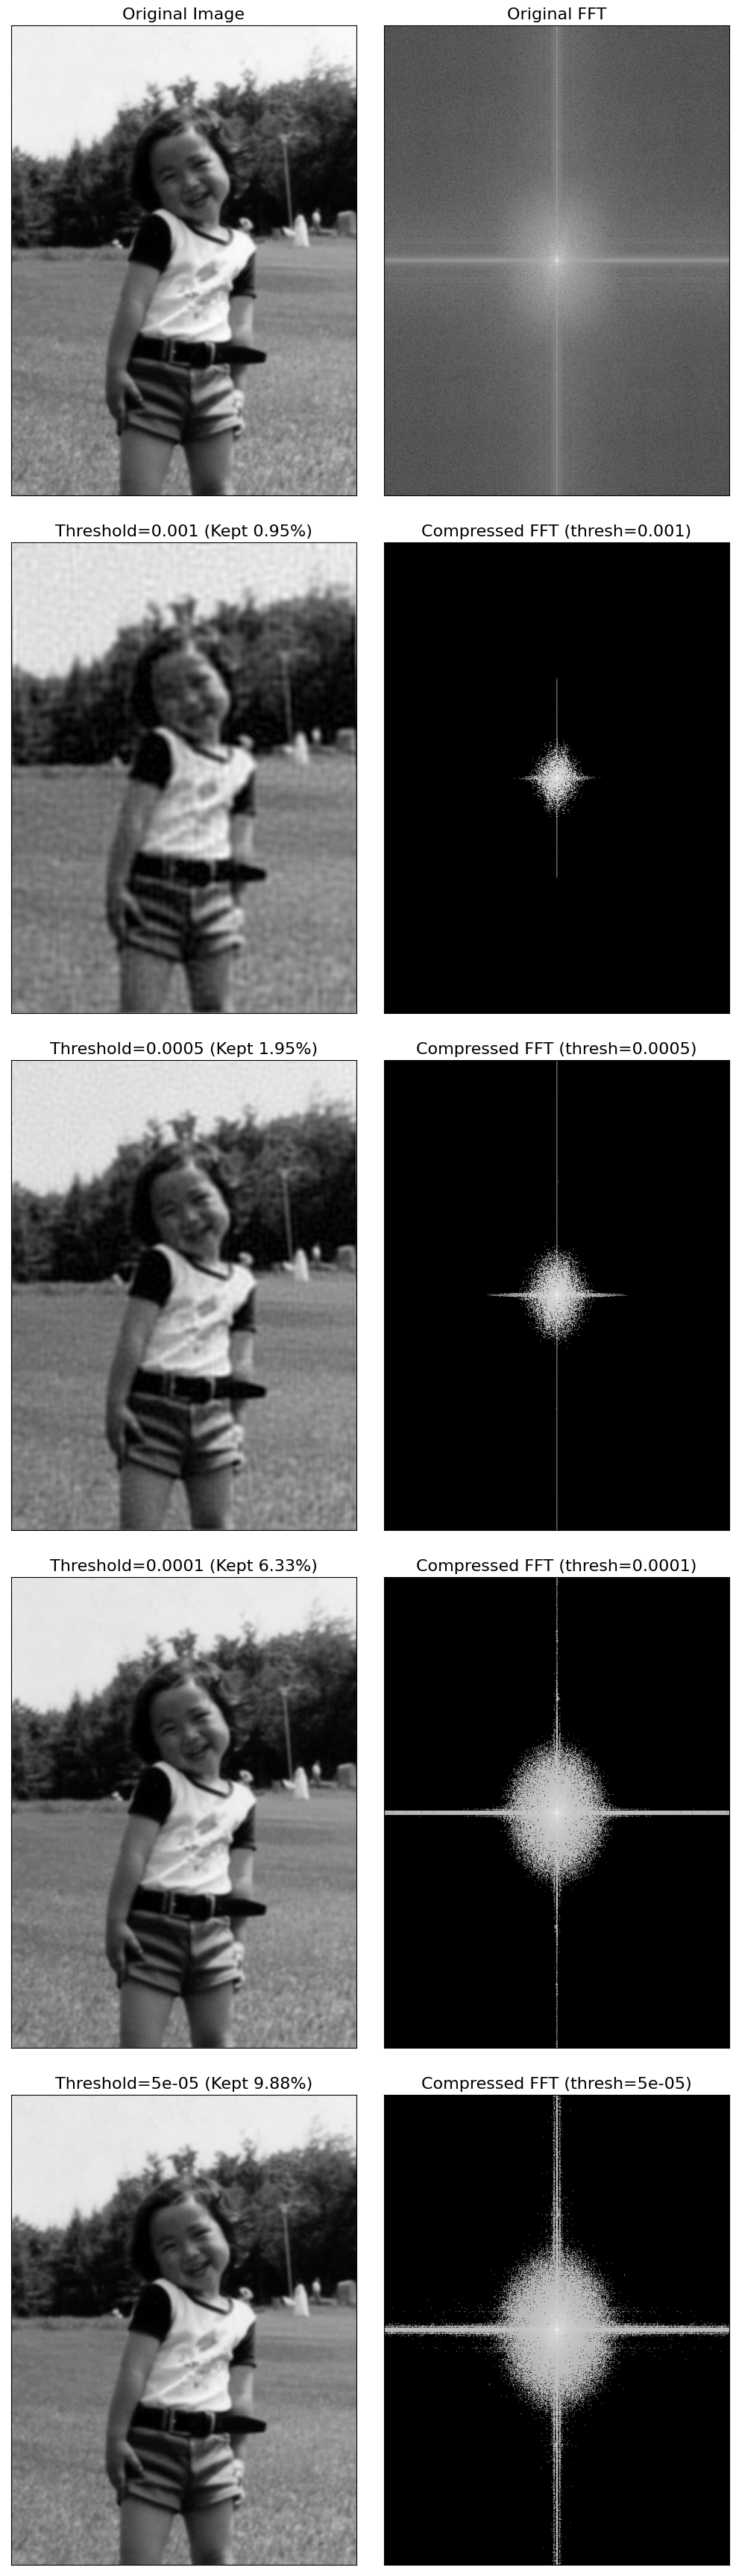

In [2]:
# Show how to compress the image in frequency domain by zeroing out high frequencies
def compress_image(image_fft, threshold=0.1):
    # Create a mask to zero out high frequencies
    magnitude = torch.abs(image_fft)
    mask = magnitude > threshold * magnitude.max()
    compressed_fft = image_fft * mask

    # Calculate compression ratio (percentage of coefficients retained)
    compression_ratio = mask.sum().item() / mask.numel() * 100
    return compressed_fft, compression_ratio

# Try different threshold levels
thresholds = [1e-3, 5e-4, 1e-4, 5e-5]

# Get image dimensions to calculate aspect ratio
C, H, W = image.shape
aspect_ratio = W / H
num_rows = len(thresholds) + 1
num_cols = 2

# Create a figure with proper size
fig_width = 10  # inches
fig_height = fig_width * (num_rows / num_cols) / aspect_ratio
fig = plt.figure(figsize=(fig_width, fig_height))

# Use gridspec for more control
from matplotlib import gridspec
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1, 1], wspace=0, hspace=0.1)

# First, show the original image
ax = fig.add_subplot(gs[0, 0])
ax.imshow(image.squeeze(), cmap='gray')
ax.set_title('Original Image', fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[0, 1])
ax.imshow(torch.log(torch.abs(image_fft) + 1e-8).squeeze(), cmap='gray')
ax.set_title('Original FFT', fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Then show different compression levels
for i, threshold in enumerate(thresholds):
    compressed_fft, ratio = compress_image(image_fft, threshold=threshold)
    image_compressed = torch.fft.ifft2(torch.fft.ifftshift(compressed_fft))
    
    ax = fig.add_subplot(gs[i+1, 0])
    ax.imshow(torch.abs(image_compressed).squeeze(), cmap='gray')
    ax.set_title(f'Threshold={threshold} (Kept {ratio:.2f}%)', fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(gs[i+1, 1])
    ax.imshow(torch.log(torch.abs(compressed_fft) + 1e-8).squeeze(), cmap='gray')
    ax.set_title(f'Compressed FFT (thresh={threshold})', fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust figure to fill window
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0.1)

plt.show()

### **Compression by Cropping Central Window**

RMSE for 16x16 FFT: 24.6886
RMSE for 32x32 FFT: 16.7355
RMSE for 64x64 FFT: 9.6200
RMSE for 128x128 FFT: 4.8356
RMSE for 256x256 FFT: 2.8304
RMSE for 512x512 FFT: 1.4722


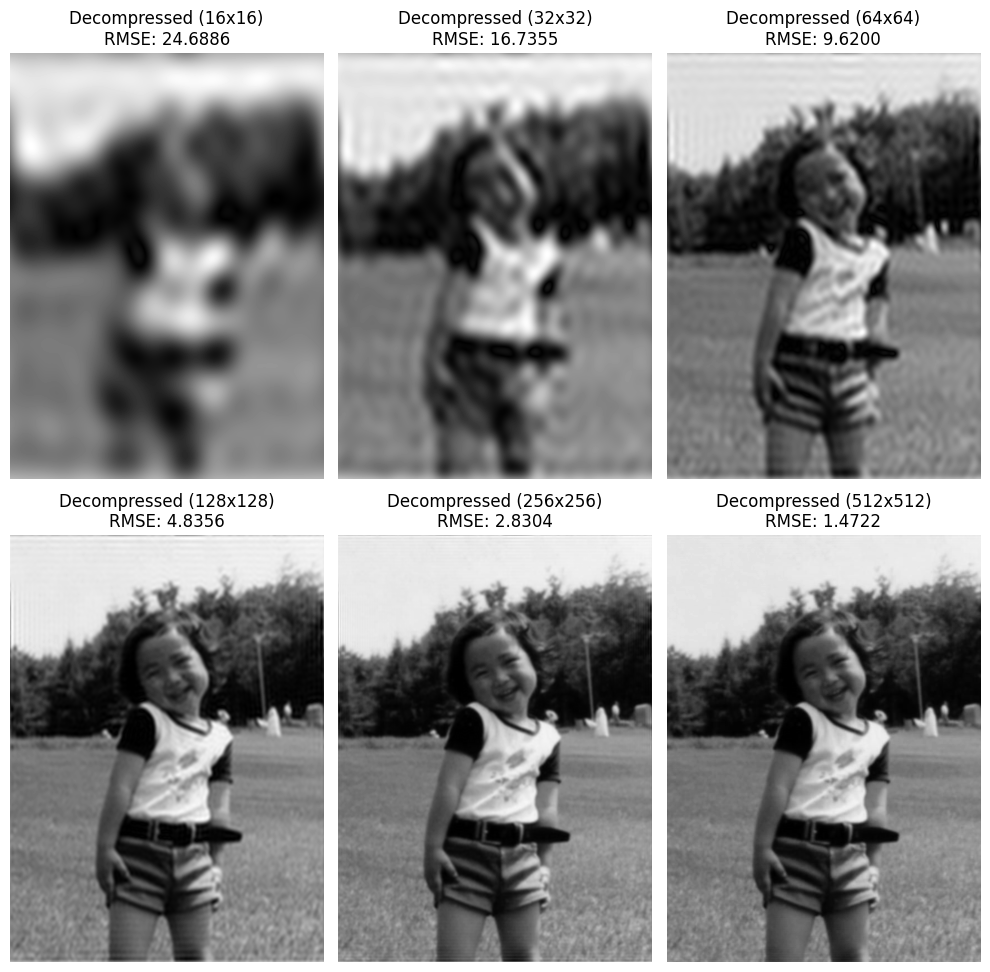

In [3]:
def compress_by_fft_truncation(image, fft_size):
    """
    Compresses an image by performing a full FFT, cropping the central
    (low-frequency) part, and then decompressing.
    """
    # 1. Get original dimensions
    _, H, W = image.shape
    
    # 2. Perform FFT on the full original image and shift the zero-frequency to the center
    image_fft = torch.fft.fftshift(torch.fft.fft2(image))

    # 3. Crop the center of the frequency domain data to fft_size
    # This keeps the low frequencies and discards high frequencies.
    center_h, center_w = H // 2, W // 2
    half_fft_h, half_fft_w = fft_size // 2, fft_size // 2
    
    start_h, end_h = center_h - half_fft_h, center_h + half_fft_h
    start_w, end_w = center_w - half_fft_w, center_w + half_fft_w
    
    cropped_fft = image_fft[:, start_h:end_h, start_w:end_w]

    # 4. To decompress, pad the cropped FFT back to the original size with zeros
    pad_top = start_h
    pad_bottom = H - end_h
    pad_left = start_w
    pad_right = W - end_w
    
    padded_fft = F.pad(cropped_fft, (pad_left, pad_right, pad_top, pad_bottom), "constant", 0)

    # 5. Perform inverse shift and inverse FFT on the padded data
    image_decompressed = torch.fft.ifft2(torch.fft.ifftshift(padded_fft))
    
    return image_decompressed

def calculate_rmse(original, decompressed):
    # Calculate RMSE. Use torch.abs() as decompressed image is complex.
    return torch.sqrt(torch.mean((torch.abs(original) - torch.abs(decompressed)) ** 2)).item()

# Define FFT sizes to test
fft_sizes = [16, 32, 64, 128, 256, 512]

# Create a 2x2 figure to display results
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

for i, fft_size in enumerate(fft_sizes):
    # Compress and decompress the image using the correct method
    image_decompressed = compress_by_fft_truncation(image, fft_size)

    # Calculate the overall RMSE between the original and decompressed images
    overall_rmse = calculate_rmse(image, image_decompressed) * 255.0  # Scale RMSE to [0, 255] range
    print(f"RMSE for {fft_size}x{fft_size} FFT: {overall_rmse:.4f}")

    # Show the decompressed image in the subplot
    # Use torch.abs() because the output of ifft2 is complex
    axs[i].imshow(torch.abs(image_decompressed).squeeze().detach().numpy(), cmap='gray')
    axs[i].set_title(f'Decompressed ({fft_size}x{fft_size})\nRMSE: {overall_rmse:.4f}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()